1. INSTALASI LIBRARY

In [8]:
!pip install -q tensorflow kaggle matplotlib numpy

2. IMPORT LIBRARY

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

3. SETUP KAGGLE API

In [10]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Setup Kaggle API

In [17]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


4. DOWNLOAD DAN EKSTRAK DATASET

In [18]:
# Hapus folder lama jika ada
!rm -rf /content/fruits_dataset

# Download dataset
!kaggle datasets download -d moltean/fruits

# Ekstrak dataset
!unzip -q fruits.zip -d fruits_dataset

# Verifikasi struktur folder
!ls /content/fruits_dataset

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
fruits.zip: Skipping, found more recently modified local copy (use --force to force download)
fruits-360_100x100	   fruits-360_dataset_meta  fruits-360_original-size
fruits-360_3-body-problem  fruits-360_multi


5. CEK STRUKTUR FOLDER DAN TENTUKAN PATH

In [19]:
import os

# Cari path training yang benar
base_dir = '/content/fruits_dataset'
train_dir = None
test_dir = None

for root, dirs, _ in os.walk(base_dir):
    if 'Training' in dirs:
        train_dir = os.path.join(root, 'Training')
    if 'Test' in dirs:
        test_dir = os.path.join(root, 'Test')

# Jika tidak ditemukan dengan nama standar
if train_dir is None or test_dir is None:
    for root, dirs, _ in os.walk(base_dir):
        if 'train' in dirs:
            train_dir = os.path.join(root, 'train')
        if 'test' in dirs:
            test_dir = os.path.join(root, 'test')

assert train_dir is not None, "Folder training tidak ditemukan"
assert test_dir is not None, "Folder test tidak ditemukan"

print(f"Training directory: {train_dir}")
print(f"Test directory: {test_dir}")

Training directory: /content/fruits_dataset/fruits-360_3-body-problem/fruits-360-3-body-problem/Training
Test directory: /content/fruits_dataset/fruits-360_3-body-problem/fruits-360-3-body-problem/Test


6. PREPROCESSING DATA

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya normalisasi untuk validasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

Found 34800 images belonging to 3 classes.
Found 12233 images belonging to 3 classes.


7. BANGUN MODEL CNN

In [21]:
num_classes = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,371,075 (12.86 MB)

 Trainable params: 3,371,075 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

8. TRAINING MODEL

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stop]
)

Epoch 1/30
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 732s 673ms/step - accuracy: 0.9833 - loss: 0.0536 - val_accuracy: 0.8716 - val_loss: 2.9473
Epoch 2/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 8:24 465ms/step - accuracy: 0.9688 - loss: 0.0485

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 67s 61ms/step - accuracy: 0.9688 - loss: 0.0485 - val_accuracy: 0.8753 - val_loss: 2.9297
Epoch 3/30
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 736s 675ms/step - accuracy: 0.9853 - loss: 0.0426 - val_accuracy: 0.8599 - val_loss: 3.1345
Epoch 4/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 8:31 471ms/step - accuracy: 0.9688 - loss: 0.0491

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - accuracy: 0.9688 - loss: 0.0491 - val_accuracy: 0.8606 - val_loss: 3.0911
Epoch 5/30
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 745s 685ms/step - accuracy: 0.9892 - loss: 0.0324 - val_accuracy: 0.8829 - val_loss: 2.2754
Epoch 6/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 8:52 490ms/step - accuracy: 0.9688 - loss: 0.0569

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 62s 57ms/step - accuracy: 0.9688 - loss: 0.0569 - val_accuracy: 0.8847 - val_loss: 2.2920
Epoch 7/30
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 802s 688ms/step - accuracy: 0.9902 - loss: 0.0285 - val_accuracy: 0.8731 - val_loss: 2.3919
Epoch 8/30
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 8:32 472ms/step - accuracy: 1.0000 - loss: 0.0176

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 83s 76ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 0.8689 - val_loss: 2.3922


9. EVALUASI MODEL

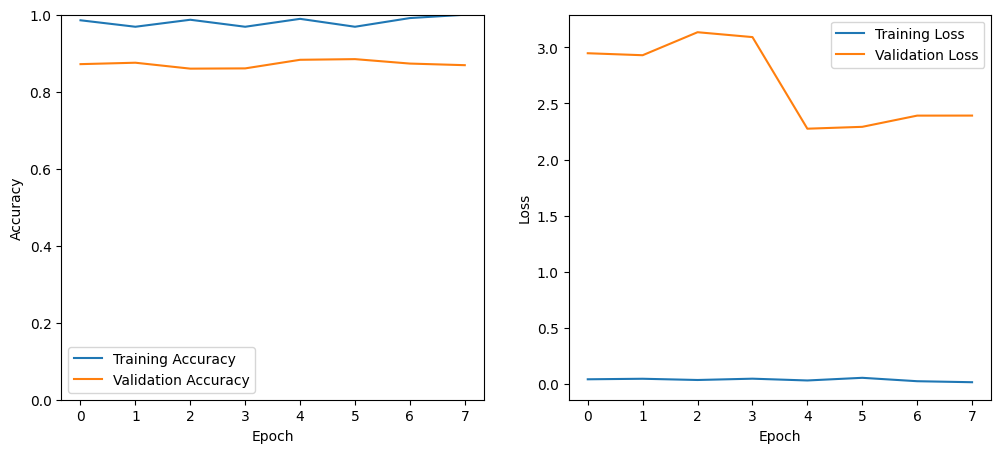

In [24]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()